## Assignment: $k$ Means Clustering

### `! git clone https://github.com/ds3001f25/clustering_assignment.git`

### **Do two questions in total: "Q1+Q2" or "Q1+Q3"**

# q1 

**Q1.** This is a question about clustering. We want to investigate how adjusting the "noisiness" of the data impacts the quality of the algorithm and the difficulty of picking $k$.

1. Run the code below, which creates four datasets: `df0_125`, `df0_25`, `df0_5`, `df1_0`, and `df2_0`. Each data set is created by increasing the amount of `noise` (standard deviation) around the cluster centers, from `0.125` to `0.25` to `0.5` to `1.0` to `2.0`.

```
import numpy as np
import pandas as pd

def createData(noise,N=50):
    np.random.seed(100) # Set the seed for replicability
    # Generate (x1,x2,g) triples:
    X1 = np.array([np.random.normal(1,noise,N),np.random.normal(1,noise,N)])
    X2 = np.array([np.random.normal(3,noise,N),np.random.normal(2,noise,N)])
    X3 = np.array([np.random.normal(5,noise,N),np.random.normal(3,noise,N)])
    # Concatenate into one data frame
    gdf1 = pd.DataFrame({'x1':X1[0,:],'x2':X1[1,:],'group':'a'})
    gdf2 = pd.DataFrame({'x1':X2[0,:],'x2':X2[1,:],'group':'b'})
    gdf3 = pd.DataFrame({'x1':X3[0,:],'x2':X3[1,:],'group':'c'})
    df = pd.concat([gdf1,gdf2,gdf3],axis=0)
    return df

df0_125 = createData(0.125)
df0_25 = createData(0.25)
df0_5 = createData(0.5)
df1_0 = createData(1.0)
df2_0 = createData(2.0)
```

2. Make scatterplots of the $(X1,X2)$ points by group for each of the datasets. As the `noise` goes up from 0.125 to 2.0, what happens to the visual distinctness of the clusters?
3. Create a scree plot for each of the datasets. Describe how the level of `noise` affects the scree plot (particularly the presence of a clear "elbow") and your ability to definitively select a $k$. (Pay attention to the vertical axis across plots, or put all the scree curves on a single canvas.)
4. Explain the intuition of the elbow, using this numerical simulation as an example.

In [1]:
import numpy as np
import pandas as pd

def createData(noise,N=50):
    np.random.seed(100) # Set the seed for replicability
    # Generate (x1,x2,g) triples:
    X1 = np.array([np.random.normal(1,noise,N),np.random.normal(1,noise,N)])
    X2 = np.array([np.random.normal(3,noise,N),np.random.normal(2,noise,N)])
    X3 = np.array([np.random.normal(5,noise,N),np.random.normal(3,noise,N)])
    # Concatenate into one data frame
    gdf1 = pd.DataFrame({'x1':X1[0,:],'x2':X1[1,:],'group':'a'})
    gdf2 = pd.DataFrame({'x1':X2[0,:],'x2':X2[1,:],'group':'b'})
    gdf3 = pd.DataFrame({'x1':X3[0,:],'x2':X3[1,:],'group':'c'})
    df = pd.concat([gdf1,gdf2,gdf3],axis=0)
    return df

df0_125 = createData(0.125)
df0_25 = createData(0.25)
df0_5 = createData(0.5)
df1_0 = createData(1.0)
df2_0 = createData(2.0)

In [2]:
def maxmin(x): # max min from notes + epsilon to avoid div by 0 error !!!!
    denom = (np.max(x) - np.min(x))
    return (x - np.min(x)) / denom if denom != 0 else np.zeros_like(x)

def scale_columns_minmax(X):
    X_scaled = np.zeros_like(X, dtype=float)
    # column 0
    X_scaled[:, 0] = maxmin(X[:, 0])
    # column 1
    X_scaled[:, 1] = maxmin(X[:, 1])
    return X_scaled

datasets = [
    ("noise=0.125", df0_125),
    ("noise=0.25",  df0_25),
    ("noise=0.5",   df0_5),
    ("noise=1.0",   df1_0),
    ("noise=2.0",   df2_0),
]

### 1.2

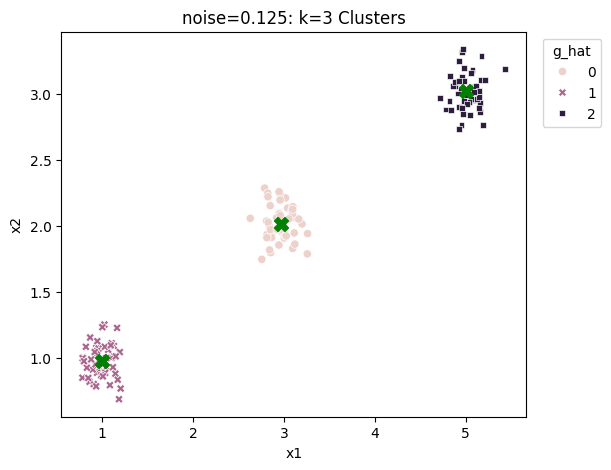

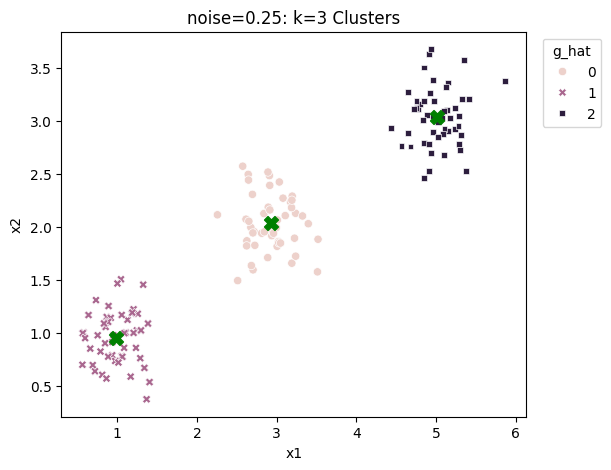

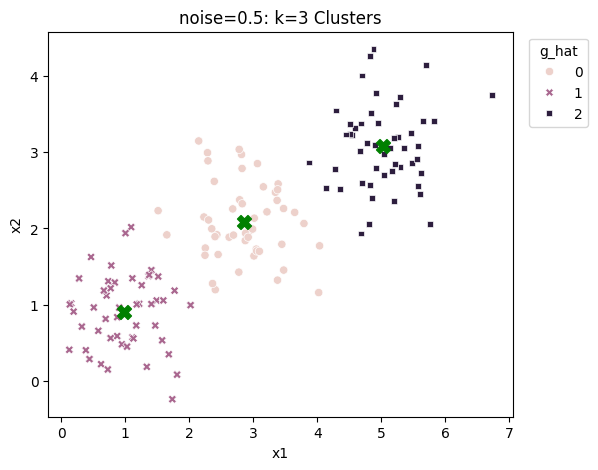

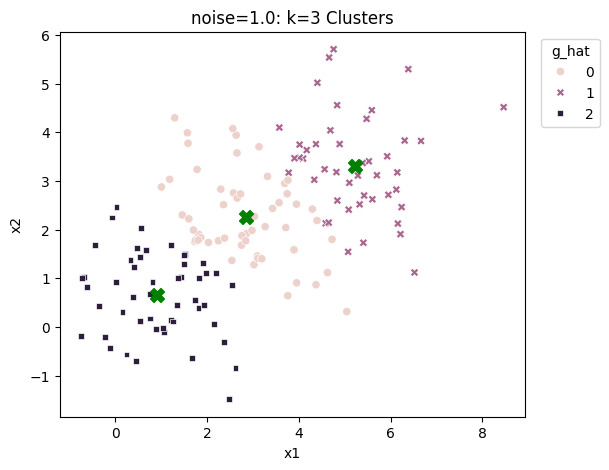

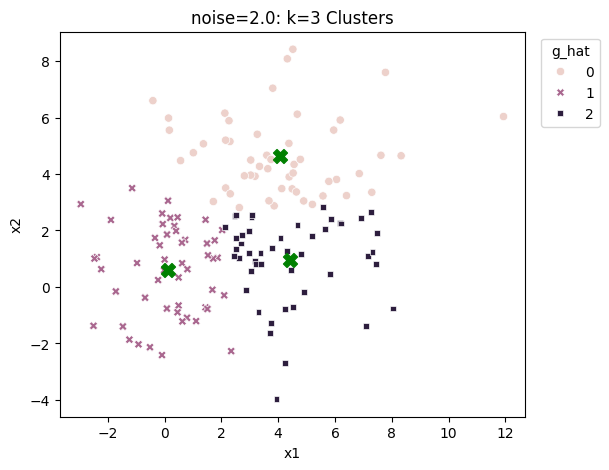

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

def plot_kmeans_scatter(df, label="", k=3, random_state=0):
    X = df[['x1', 'x2']].to_numpy()
    min_x1, max_x1 = X[:, 0].min(), X[:, 0].max()
    min_x2, max_x2 = X[:, 1].min(), X[:, 1].max()
    X_scaled = scale_columns_minmax(X)

    # fit to kmeans
    model = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    model.fit(X_scaled)

    # adding preditctions to df
    df = df.copy()
    df['g_hat'] = model.predict(X_scaled)

    # converting centroids back to original scale
    centers = model.cluster_centers_
    centroid_x_1 = centers[:, 0] * (max_x1 - min_x1) + min_x1
    centroid_x_2 = centers[:, 1] * (max_x2 - min_x2) + min_x2

    # plots the clusters + centroids
    plt.figure(figsize=(6, 5))
    ax = sns.scatterplot(data=df, x='x1', y='x2',
                         hue='g_hat', style='g_hat')
    ax.scatter(centroid_x_1, centroid_x_2,
               color='green', s=100, marker='X')
    ax.set_title(f'{label}: k={k} Clusters')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 1), title="g_hat")
    plt.show()

    return df, np.column_stack([centroid_x_1, centroid_x_2])

for name, df in datasets:
    plot_kmeans_scatter(df, label=name, k=3)   # cluster scatterplot


As noise increases, the visual distinctness of the plots decrease and it is harder to tell where each cluster is truly separated in plots with higher noise.

### 1.3

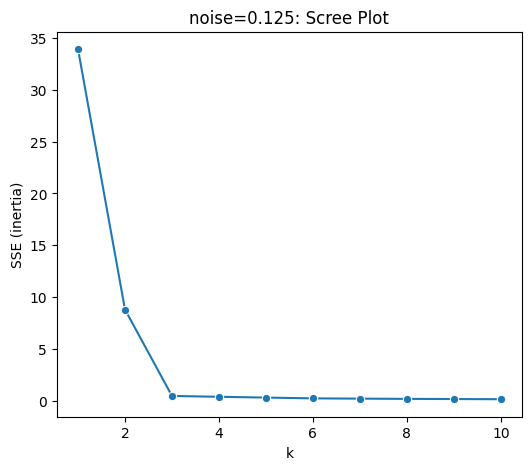

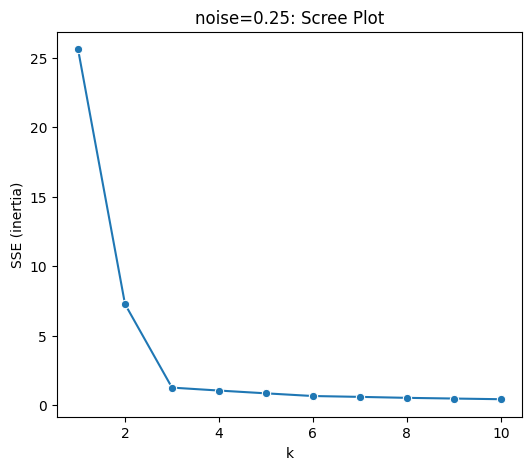

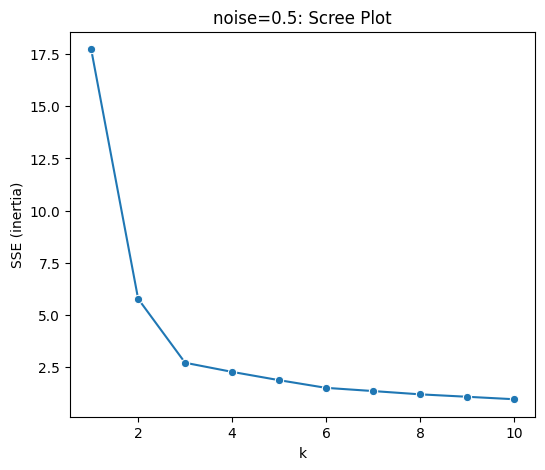

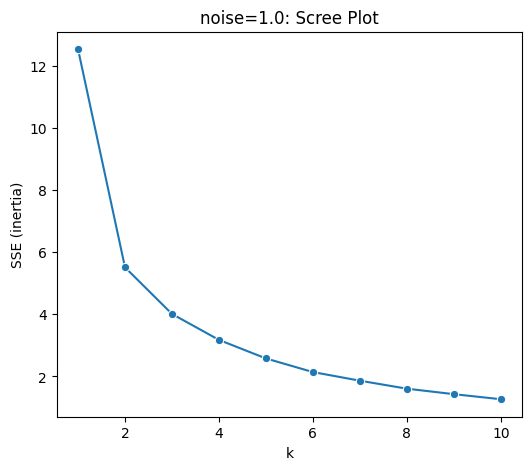

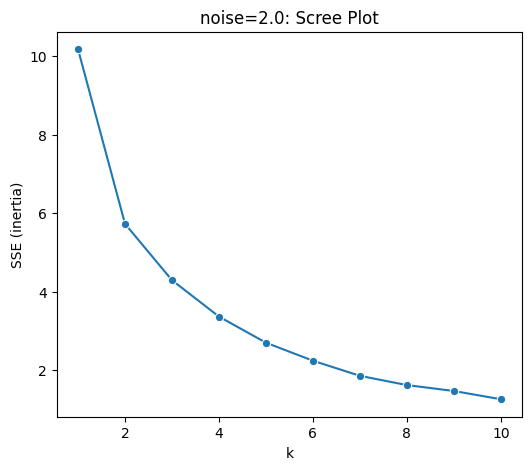

In [4]:
# plotting scree, which is SSE vs k
def plot_scree(df, label="", k_bar=10, random_state=0):
    X = df[['x1', 'x2']].to_numpy()
    X_scaled = scale_columns_minmax(X)

    SSE = []
    for k in range(1, k_bar + 1):
        km = KMeans(n_clusters=k, max_iter=300, n_init=10, random_state=random_state)
        km.fit(X_scaled)
        SSE.append(km.inertia_)
        

    plt.figure(figsize=(6, 5))
    ax = sns.lineplot(x=np.arange(1, k_bar + 1), y=SSE, marker='o')
    ax.set_xlabel('k')
    ax.set_ylabel('SSE (inertia)')
    ax.set_title(f'{label}: Scree Plot')
    plt.show()

    return SSE

for name, df in datasets:
    plot_scree(df, label=name, k_bar=10) 

The higher the noise, the harder it is to really determine where the elbow lies. For just a lower noise, the scree plot has a very evident elbow/drop off around k=3 and then it levels off. A moderate amount of noise (0.5,1.0) makes it a bit more difficult to clearly see where the best k option is, but it does still seem to be 3. But at the higher amounts, the elbow is almost non existent and the curve flattens out too quickly to determine where the best k would really lie.

### 1.4
The whole point of the elbow method is getting both a good quality fit and a good amount of complexity for our model since my increasing k, K-means will lower the SSE since more centroids means the clusters are tighter and experience less noise. Each additional cluster does explain bigger drops in SSE (aka more variance) but one we get the best option of k for the number of clusters, adding more clusters no longer has as much of an impact on the imrpovement. THe elbow point is the value of k where the curve in SSE changes from steep to shallow, which means the point beyond it just has extra complexity that doesn't give any benefit to the model. 
</br> </br>
In this case, it's evident that adding more than 3 clusters doesn't reduce the SSE much which indicates the data just naturally has 3 clusters and K-means also works pretty well here when the clusters are more separated like we see with our noise options. 

**Q2.** This question is a case study on clustering.

1. Load the `2022 election cycle fundraising.csv` file in the `./data` folder. This has campaign finance data for the 2022 election for House and Senate candidates. We're going to focus on the total amount they raised, `Raised`, the total amount they spent, `Spent`, their available `Cash on Hand`, and their `Debts`. The variables denominated in dollars are messy and require cleaning. How do you handle it?
2. Max-min normalize `Raised` and `Spent`. Use a scree plot to determine the optimal number of clusters for the $k$ means clustering algorithm. Make a scatter plot of `Raised` against `Spent` and hue the dots by their cluster membership. What do you see? Which politicians comprise the smallest two clusters? If necessary, look up some of these races to see how close they were.
3. Repeat part 2, but for `Cash on Hand` and `Debts`. Compare your results with part 2. Why might this be? If necessary, look up some of these races to see how close they were.
4. Use $k$ means clustering with all four numeric variables. How do your results compare to the previous two parts?
5. Did the $k$-MC algorithm find useful patterns for you in analyzing the election?

# q3

**Q3.** This question is a case study on clustering.

1. Load the `SIPRI Military Expenditure Database.csv` file in the `./data` folder. This has data about military spending by country. Filter the rows to select only the year 2020, and drop all rows with missing values. I ended up with 148 countries. Is any further cleaning of the variables required?
2. Max-min normalize `Spending (2020 USD)` and `Spending per Capita`. Use a scree plot to determine the optimal number of clusters for the $k$ means clustering algorithm. Make a scatter plot of `Spending (2020 USD)` and `Spending per Capita`, and hue the dots by their cluster membership. Compute a describe table conditional on cluster membership (i.e. `.groupby(cluster).describe()`). What do you see? Where is the United States? Do you notice any patterns in the cluster membership?
3. Repeat part 2 for `Percent of Government Spending` and `Percent of GDP`. How do your results compare to part 2?
4. Use $k$ means clustering with all four numeric variables: `Spending (2020 USD)`, `Spending per Capita`, `Percent of Government Spending`, and `Percent of GDP`. How do your results compare to the previous two parts? 
5. Did the $k$-MC algorithm find any useful patterns for you in analyzing the spending?

In [24]:
df = pd.read_csv("./data/SIPRI Military Expenditure Database.csv")

# only 2020
df_2020 = df[df["Year"] == 2020]

# dropping missing values
df_2020 = df_2020.dropna(subset=["Spending (2020 USD)", "Spending per Capita"])

print(len(df_2020))  # should be ~148 ?


148


In [22]:
df_2020.head()

,index,Year,Country,Spending (2020 USD),Percent of GDP,Percent of Government Spending,Spending per Capita,Spending_norm,SpendingPC_norm,cluster
32,32,2020,Afghanistan,279.576955,0.013589,0.049728,7.181899,0.000348,0.002620,0
66,66,2020,Albania,187.433234,0.012583,0.037952,65.126211,0.000230,0.025615,0
100,100,2020,Algeria,9708.277440,0.066600,0.173924,221.392384,0.012461,0.087630,0
134,134,2020,Angola,993.594405,0.014442,0.074624,30.231680,0.001265,0.011767,0
168,168,2020,Argentina,2830.929705,0.007269,0.017268,62.636731,0.003626,0.024627,0


### 3.2

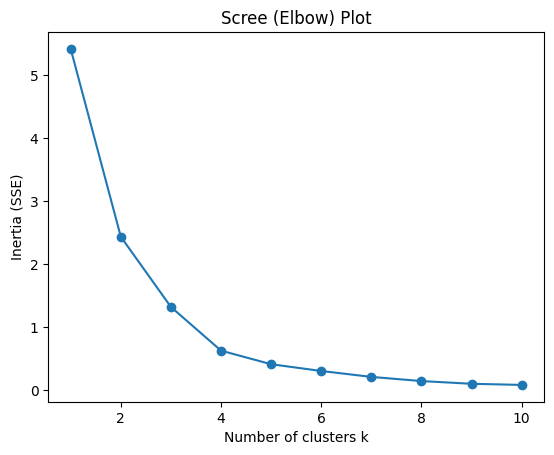

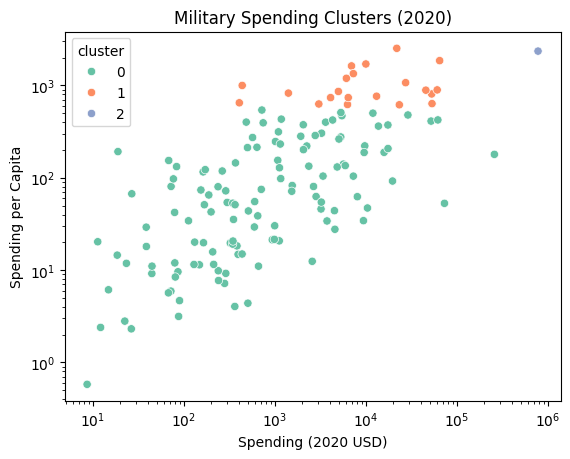

In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_2020[["Spending_norm", "SpendingPC_norm"]] = scaler.fit_transform(
    df_2020[["Spending (2020 USD)", "Spending per Capita"]]
)

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X = df_2020[["Spending_norm", "SpendingPC_norm"]]

inertia = []
k_range = range(1, 11)  # test k = 1..10
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertia.append(km.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel("Number of clusters k")
plt.ylabel("Inertia (SSE)")
plt.title("Scree (Elbow) Plot")
plt.show()

optimal_k = 3
km = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_2020["cluster"] = km.fit_predict(X)

import seaborn as sns
sns.scatterplot(
    data=df_2020,
    x="Spending (2020 USD)", 
    y="Spending per Capita",
    hue="cluster",
    palette="Set2"
)
plt.xscale("log")   # helps with skew in spending
plt.yscale("log")
plt.title("Military Spending Clusters (2020)")
plt.show()


In [23]:
summary = df_2020.groupby("cluster")[["Spending (2020 USD)", "Spending per Capita"]].describe()
print(summary)

# Where is the United States?
usa = df_2020[df_2020["Country"] == "United States of America"]
print(usa[["Country", "Spending (2020 USD)", "Spending per Capita", "cluster"]])


        Spending (2020 USD)                                              \
                      count           mean           std            min   
cluster                                                                   
0                     126.0    5943.346303  24858.961064       8.622460   
1                      21.0   19975.991473  21749.736747     405.790494   
2                       1.0  778397.200000           NaN  778397.200000   

                                                                     \
                   25%            50%            75%            max   
cluster                                                               
0           162.761743     580.758315    3225.333414  257973.429834   
1          4980.428135    7269.880030   27300.894701   64558.400000   
2        778397.200000  778397.200000  778397.200000  778397.200000   

        Spending per Capita                                        \
                      count         mean         std 

The US is completely in it's own cluster(cluster 2) due to it's insanely high spending ($778B and also spends $2351 per capita). Otherwise, the cluster membership is split reasonably where cluster 0 is 126 countries that are very low to moderate spenders which consists of the majority of the world but cluster 1 have a higher mean spending (around $20b) which is made up of 21 countries, such as western european countries.

### 3.3

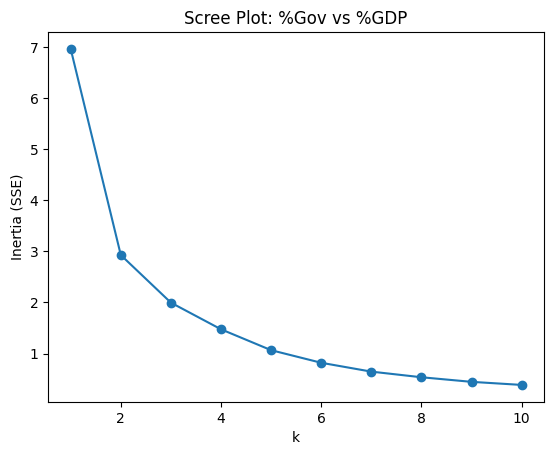

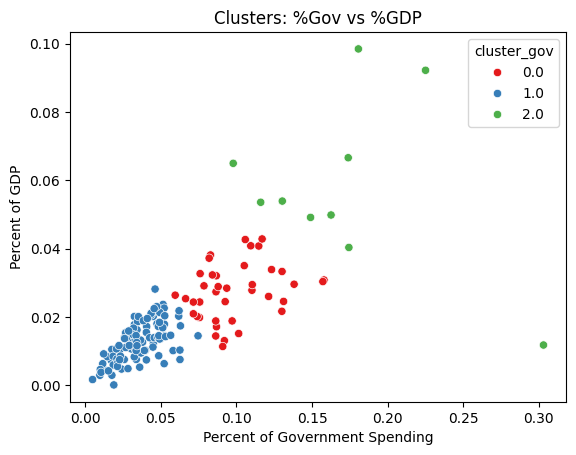

In [27]:
X_gov = df_2020[["Percent of Government Spending", "Percent of GDP"]].dropna()
X_gov_norm = scaler.fit_transform(X_gov)

# elbow plot
inertia = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_gov_norm)
    inertia.append(km.inertia_)

plt.plot(range(1, 11), inertia, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia (SSE)")
plt.title("Scree Plot: %Gov vs %GDP")
plt.show()

# supposedly... elbow of around 3 clusters
km = KMeans(n_clusters=3, random_state=42, n_init=10)
df_2020.loc[X_gov.index, "cluster_gov"] = km.fit_predict(X_gov_norm)

sns.scatterplot(
    data=df_2020,
    x="Percent of Government Spending", 
    y="Percent of GDP", 
    hue="cluster_gov", 
    palette="Set1"
)
plt.title("Clusters: %Gov vs %GDP")
plt.show()

It seems that the US is no longer an extreme outlier as it is more in the middle in terms of %GDP and the clustering has changed here where there are now clusters based on:
1. countries with high % gdp (which tend to be high military burden)
2. countries with average % gdp values
3. countries with pretty low burden

### 3.4

In [ ]:
# select features and drop missing
features = ["Spending (2020 USD)", "Spending per Capita",
            "Percent of Government Spending", "Percent of GDP"]
X_all = df_2020[features].dropna()

scaler = MinMaxScaler()
X_all_norm = scaler.fit_transform(X_all)

km = KMeans(n_clusters=3, random_state=42, n_init=10)
df_2020.loc[X_all.index, "cluster_all"] = km.fit_predict(X_all_norm)

summary_all = df_2020.groupby("cluster_all")[features].describe()
print(summary_all)

# looking @ example countries per cluster
for c in sorted(df_2020["cluster_all"].unique()):
    print(f"\nCluster {c}:")
    print(df_2020[df_2020["cluster_all"] == c][["Country"] + features].head(10))


            Spending (2020 USD)                                             \
                          count           mean            std          min   
cluster_all                                                                  
0.0                        31.0    8786.086602   17901.909108   162.373364   
1.0                         6.0  147964.582042  309635.189564  6095.708713   
2.0                       111.0    7086.472777   26479.379918     8.622460   

                                                                     \
                     25%           50%           75%            max   
cluster_all                                                           
0.0           467.787851   1404.787234   7739.166193   72937.064048   
1.0          7700.424616  15897.570598  53872.942442  778397.200000   
2.0           130.010211    567.650747   3910.107493  257973.429834   

            Spending per Capita               ...  \
                          count         mean  ...  

The clustering on all four variables produces three groups. Cluster 1 contains just 6 countries, and it is dominated by the United States, which drives the averages sky-high with its extraordinary spending ($778B, over $2,300 per capita). This small group also includes a few very high per-capita spenders, likely wealthy petro-states or small NATO members with outsized defense burdens.

Cluster 0 (31 countries) represents states with moderate total spending (median around $1.4B) but higher than average relative burdens: per-capita spending above $200 and government/military ratios that are noticeably higher. These are countries that don’t spend U.S.-level sums, but whose populations feel the military budget more directly — think of smaller European and Middle Eastern countries.

Cluster 2 (111 countries) contains the bulk of the world. These states spend relatively little in both absolute and per-capita terms (median around $568 per person and just half a billion to a few billion in totals). Their defense budgets also make up the smallest shares of GDP and government expenditure.

Overall, the U.S. still stands apart in its own cluster because of extreme absolute and per-capita levels. Including %GDP and %Government Spending sharpened the distinction for some smaller countries (Cluster 0), pulling them away from the “bulk” and highlighting their relatively heavy military burden despite modest budgets. The majority of the world (Cluster 2) remains in the low-spending group.

### 3.5

When clustering by % of Government Spending and % of GDP, the US no longer stood out; instead, small poorer countries with unusually high military burdens became the outliers. But when all four variables were used, the U.S. returned to its own extreme cluster along with a few very high per capita spenders, while a smaller group of moderate spenders with heavier burdens split off from the majority of countries, which remained low in both absolute and relative terms. Overall, k means highlighted three clear types of spenders: the US as a unique outlier, a small set of wealthy or high burden states, and the vast majority of countries that spend very little.